In [1]:
# parity = (-1)^{number of 1s in the bit repn of b below position j}
function fermion_parity(b::Int64, j::Int64)
  mask = (1 << (j-1)) - 1
  parity  = count_ones(b & mask) & 1
  return 1 - (parity << 1)
end

fermion_parity (generic function with 1 method)

In [2]:
function int2bits(b::Int64, N::Int64)::BitVector
  v = BitVector(undef, N)      # single allocation: ceil(N/64) machine words

  @inbounds @simd for i in 1:N
    v[i] = Bool( b >> (i-1) & 0x1 )
  end

  return v
end

int2bits (generic function with 1 method)

In [3]:
@inline function bitvec2idx(bits::AbstractVector{Bool})::Int64
  val::UInt64 = 0

  @inbounds @simd for i in 1:length(bits)
    val |= UInt64(bits[i]) << (i-1)
  end
  
  return Int64(val)
end

bitvec2idx (generic function with 1 method)

In [4]:
# project onto particle_num=k sector
function proj_ptl_sector(k::Int64, N::Int64)
  dim = binomial(N, k)
  proj_mat = spzeros(Int64, dim, 2^N)
  
  row = 1
  for idx=0:(2^N-1)
    n = sum(int2bits(idx, N))
    if n == k
      proj_mat[row, 1 + idx] = 1
      row += 1
    end
  end

  proj_mat
end

proj_ptl_sector (generic function with 1 method)

In [5]:
# Apply c_j or c^dag_j to basis state b
# returns (new_state, amplitude) or nothing
function apply_c(b::Int64, j::Int64; dag::Bool=false)
  bit = (b >> (j-1)) & 1
  if !dag && bit == 0
    return nothing
  elseif dag && bit == 1
    return nothing
  end

  # parity factor from anticommutation
  sign = fermion_parity(b, j)
  # flip bit j
  newb = dag ? (b | (1 << (j-1))) : (b & ~(1 << (j-1)))
  return newb, sign
end

apply_c (generic function with 1 method)

In [6]:
using SparseArrays
function build_c(j::Int64, N::Int64; dag::Bool=false)
  dim = 1 << N
  rows, cols, vals = Int64[], Int64[], Int64[]
  for b in 0:(dim-1)
    out = apply_c(b, j; dag)
    if out !== nothing
      b2, s = out
      push!(rows, b2 + 1)
      push!(cols, b + 1)
      push!(vals, s)
    end
  end
  return sparse(rows, cols, vals, dim, dim)
end

build_c (generic function with 1 method)

In [ ]:
[(int2bits(i, 3), bitvec2idx(int2bits(i, 3))) for i=0:7]

In [ ]:
proj_ptl_sector(1, 3)

In [ ]:
[fermion_parity(i, 3) for i=0:7]

In [ ]:
build_c(3, 3)

In [ ]:
build_c(3, 3; dag=true)

In [ ]:
i, j = 2, 2
build_c(i, 3) * build_c(j, 3; dag=true) + build_c(j, 3; dag=true) * build_c(i, 3)

In [ ]:
# function N_mat(N::Int64)
#   dim = 2^N

#   c_mat = [build_c(m, N) for m=1:N]
#   cdag_mat = [build_c(m, N; dag=true) for m=1:N]

#   N_mat = spzeros(Float64, dim, dim)
#   for m=1:N
#     N_mat .+= cdag_mat[m] * c_mat[m]
#   end

#   return N_mat
# end

In [7]:
using LinearAlgebra

# ham = sum_a coef_a c_{a_1}^pm c_{a_2}^pm ... c_{a_2k}^pm becomes ham_term = [pm a_1, ..., pm a_2k]=>coef_a
function build_hamiltonian(ham::Vector{Pair{Vector{Int64}, T}}, N::Int64) where T
  dim = 2^N

  c_mat = [build_c(m, N) for m=1:N]
  cdag_mat = [build_c(m, N; dag=true) for m=1:N]

  H = spzeros(T, dim, dim)

  for i=1:length(ham)
    I, coef = ham[i][1], ham[i][2]

    c_prod = I[1] > 0 ? cdag_mat[I[1]] : c_mat[-I[1]]
    for j=2:length(I)
      c_prod = I[j] > 0 ? c_prod * cdag_mat[I[j]] : c_prod * c_mat[-I[j]]
    end
        
    H .+= coef .* c_prod
  end

  return H
end

build_hamiltonian (generic function with 1 method)

In [ ]:
# function Cor_from_state(state::Vector{T}) where T
#   dim = length(state)
#   N = trailing_zeros(dim)

#   c_mat = [build_c(m, N) for m=1:N]
#   cdag_mat = [build_c(m, N; dag=true) for m=1:N]

#   Cor = zeros(T, N, N)
#   for i=1:N, j=1:N
#     Cor[i, j] = state' * cdag_mat[i] * c_mat[j] * state
#   end
    
#   return Cor
# end

In [8]:
# state_from_B, not state_from_Cor
function state_from_B(B::Matrix{T}) where T
  N, k = size(B)
  cdag_mat = [build_c(m, N; dag=true) for m=1:N]

  d_mat = [spzeros(Float64, 2^N, 2^N) for i=1:k]
  for i=1:k
    for m=1:N
      d_mat[i] .+= B[m, i] .* cdag_mat[m]
    end
  end

  state = zeros(T, 2^N)
  state[1] = 1.0

  state_ = similar(state)
  for i=k:-1:1
    mul!(state_, d_mat[i], state)
    state .= state_
  end
    
  # abs(state[1]) > 1e-3 && state ./= state[1]
    
  return state / norm(state)
end

state_from_B (generic function with 1 method)

In [9]:
using LinearAlgebra
function eigen_quad_ham(h::Matrix{T}, k::Int64) where T
  N, h_mat = size(h, 1), collect(h)
    
  eigen_h = eigen(h_mat)
  eigen_h_values, eigen_h_vectors = eigen_h.values[1:k], eigen_h.vectors[:, 1:k]
    
  return eigen_h_values, eigen_h_vectors, transpose(eigen_h_vectors * eigen_h_vectors')
end

eigen_quad_ham (generic function with 1 method)

In [ ]:
# function Cor_from_B(B)
#   return transpose(B * B')
# end

In [ ]:
# # overlap matrix for <phi(B1)|**|phi(B2)>
# function overlap_matrix(B1::Matrix{T}, B2::Matrix{T}) where T
#   return B1' * B2
# end

In [ ]:
# # transition matrix for <phi(B1)|**|phi(B2)>
# function transition_matrix(B1, B2, S)
#   return transpose( (B2 / S) * B1' )
# end

In [ ]:
# # <phi(B1)|phi(B2)>
# function overlap(S)
#   return det(S)
# end

In [ ]:
# # normal order (c_a^dagger c_b) * (c_{j1}^\dagger ... c_{jk}^\dagger c_{ik} ... c_{i1})
# # elements in J are all distinct; elements in I are all distinct
# function normal_ordering((a, b)::Tuple{Int64, Int64}, JI::Vector{Int64})
#   k = fld(length(JI), 2)
#   J, I = JI[1:k], abs.(JI[k+1:end])

#   list = Vector{Int64}[]

#   if !(a in J) && !(b in I)
#     list = Vector{Int64}[vcat(a, JI, -b)]
#   end

#   if (b in J)
#     pos = findall(x->x==b, J)
#     length(pos) > 1 && @warn "J has multiple $(b)"

#     J[pos[1]] = a

#     list = length(list) == 0 ? Vector{Int64}[vcat(J, -I)] : vcat(list, Vector{Int64}[vcat(J, -I)])
#   end

#   return list
# end

In [ ]:
# # <phi(B1)|c_{j1}^\dagger ... c_{jk}^\dagger c_{ik} ... c_{i1}|phi(B2)>/<phi(B1)|phi(B2)>
# # elements in J are all distinct; elements in I are all distinct
# function c_string_expectation(JI::Vector{Int64}, Y)
#   k = fld(length(JI), 2)
#   J, I_rev = JI[1:k], abs.(reverse(JI[k+1:end]))

#   return det(view(Y, J, I_rev))
# end

In [10]:
using LinearAlgebra

function rand_B(N::Integer, k::Int64, ::Val{T}; B0=nothing, epsilon=1.0) where T
  A = randn(T, N, N)

  if T == Float64
    A .= 0.5 .* (A .- A')
  else
    A .= 0.5im .* (A .+ A')
  end
  A = exp(epsilon * A)

  return (B0 == nothing) ? A[:, 1:k] : A * B0
end

rand_B (generic function with 1 method)

In [ ]:
# # sum of gaussians

# function sog_grams(ham::Vector{Pair{Vector{Int64}, T1}}, B_array::Vector{Matrix{T2}}) where {T1, T2}
#   k = length(B_array)
#   G, H = zeros(ComplexF64, k, k), zeros(ComplexF64, k, k)
    
#   for a=1:k
#     S = Cor_from_B(B_array[a])

#     G[a, a] = 1.0
#     for ham_term in ham
#       H[a, a] += ham_term[2] * c_string_expectation(ham_term[1], S)
#     end

#     for b=a+1:k
#       S = overlap_matrix(B_array[a], B_array[b])
#       Y = transition_matrix(B_array[a], B_array[b], S)

#       ov = overlap(S)
#       G[a, b], G[b, a] = ov, conj(ov)

#       for ham_term in ham
#         H[a, b] += ham_term[2] * c_string_expectation(ham_term[1], Y) * ov
#       end
#       H[b, a] = conj(H[a, b])
#     end
#   end
    
#   return G, H
# end

In [ ]:
# function is_gram_singular(G::Matrix{ComplexF64}; rtol=1e-12)
#   lambda = eigen(G).values

#   r = length( findall(lambda .> rtol * maximum(lambda)) )
  
#   return (r < size(G, 1))
# end

In [11]:
# forward: (a,b) -> index
function pair_to_index(a, b, N)
  return N * (a - 1) + b
end

# inverse: index -> (a,b)
function index_to_pair(k, N)
  if k <= 0 || k > N^2
    return (0, 0)
  end
    
  return (fld1(k, N), mod1(k, N))
end

index_to_pair (generic function with 1 method)

In [12]:
# forward: (a,b) -> index
function pair_to_index2(a, b, M)
#   (a == 0) && return 0
    
  offset = (a - 1) * M - fld((a - 1) * a, 2)
  return offset + (b - a)
end

# inverse: index -> (a,b)
function index_to_pair2(k, M)
  if k <= 0 || k > fld(M * (M - 1), 2)
    return (0, 0)
  end
    
  a = 1
  while true
    offset_next = a * M - fld(a * (a + 1), 2)   # offset for (a+1)-th row
    if k <= offset_next
      offset = (a - 1) * M - fld((a - 1) * a, 2)
      b = a + (k - offset)
      return (a, b)
    end
    a += 1
  end
end

index_to_pair2 (generic function with 1 method)

In [ ]:
# # overlaps[mu, I, nu, J] = <partial_I phi_mu|partial_J phi_nu> 

# # partial_{I = (a,b)} |phi> = c_a^\dagger c_b |phi>
# # partial_{I=M+1} |phi> = |phi>

# function sog_dphi_dphi!(overlaps, i::Int64, B_array)
#   k, N = length(B_array), size(B_array[1], 1)
#   M = N^2

#   for a=1:M
#     Y = Cor_from_B(B_array[i])

#     (a1, a2) = index_to_pair(a, N)
#     for b=a:M
#       (b1, b2) = index_to_pair(b, N)

#       list = normal_ordering((a2, a1), [b1, -b2])
#       overlaps[i, a, i, b] = 0
#       for string in list
#         overlaps[i, a, i, b] += c_string_expectation(string, Y)
#       end

#       (a < b) && (overlaps[i, b, i, a] = conj(overlaps[i, a, i, b]))
#     end

#     overlaps[i, M + 1, i, a] = c_string_expectation([a1, -a2], Y)
#     overlaps[i, a, i, M + 1] = conj(overlaps[i, M + 1, i, a])
#   end
#   overlaps[i, M + 1, i, M + 1] = 1.0

#   for j in deleteat!([1:k...], i)
#     S = overlap_matrix(B_array[i], B_array[j])
#     Y = transition_matrix(B_array[i], B_array[j], S)

#     ov = overlap(S)
#     overlaps[i, M + 1, j, M + 1], overlaps[j, M + 1, i, M + 1] = ov, conj(ov)

#     for a=1:M
#       (a1, a2) = index_to_pair(a, N)
#       for b=1:M
#         (b1, b2) = index_to_pair(b, N)

#         overlaps[i, a, j, b] = 0
#         list = normal_ordering((a2, a1), [b1, -b2])
#         for string in list
#           overlaps[i, a, j, b] += c_string_expectation(string, Y) * ov
#         end

#         overlaps[j, b, i, a] = conj(overlaps[i, a, j, b])
#       end

#       overlaps[i, M + 1, j, a] = c_string_expectation([a1, -a2], Y) * ov
#       overlaps[i, a, j, M + 1] = c_string_expectation([a2, -a1], Y) * ov
                
#       overlaps[j, a, i, M + 1] = conj(overlaps[i, M + 1, j, a])
#       overlaps[j, M + 1, i, a] = conj(overlaps[i, a, j, M + 1])
#     end
#   end
# end

In [ ]:
# # ovelaps[mu, I, nu] = <partial_I phi_mu|H phi_nu> 
# function sog_dphi_Hphi!(overlaps, i::Int64, ham, B_array)
#   k, N = length(B_array), size(B_array[1], 1)
#   M = N^2

#   for j=1:k
#     S = (i == j) ? Cor_from_B(B_array[i]) : overlap_matrix(B_array[i], B_array[j])
#     Y = (i == j) ? S : transition_matrix(B_array[i], B_array[j], S)

#     ov = (i == j) ? 1.0 : overlap(S)
    
#     for a=1:M
#       (a1, a2) = index_to_pair(a, N)

#       overlaps[i, a, j] = 0.0
#       for ham_term in ham
#         list = normal_ordering((a2, a1), ham_term[1])

#         for string in list
#           overlaps[i, a, j] += ham_term[2] * c_string_expectation(string, Y) * ov
#         end
#       end
#     end

#     overlaps[i, M + 1, j] = 0.0
#       for ham_term in ham
#         overlaps[i, M + 1, j] += ham_term[2] * c_string_expectation(ham_term[1], Y) * ov
#       end
#   end
# end

In [ ]:
# function sog_tdvp(i::Int64, c_array, dphi_dphi::Array{ComplexF64, 4}, dphi_Hphi::Array{ComplexF64, 3})
#   k, N = size(dphi_dphi, 1), floor(Int64, sqrt(size(dphi_dphi, 2)))
#   M, M2 = N^2, fld(N * (N - 1), 2)

#   (size(dphi_dphi, 2) != M + 1) && @warn "N and M are not consistent!"
    
#   g, A0 = zeros(ComplexF64, k, k), zeros(ComplexF64, k, M)
#   g .= view(dphi_dphi, :, M + 1, :, M + 1)
#   A0 .= view(dphi_dphi, :, M + 1, i, 1:M)

#   A1 = zeros(ComplexF64, k, M)
#   for m=1:M2, j=1:k
#     (a1, a2) = index_to_pair2(m , N)

#     m1, m2 = pair_to_index(a1, a2, N), pair_to_index(a2, a1, N)
#     A1[j, m] = A0[j, m1] - A0[j, m2]
#     A1[j, M2 + m] = 1im * (A0[j, m1] + A0[j, m2])
#   end
#   for m=1:N, j=1:k
#     m1 = pair_to_index(m, m, N)
#     A1[j, 2 * M2 + m] = 2im * A0[j, m1]
#   end

#   # assume g is non-singular
#   A_g_inv = A1' / g

#   G = zeros(Float64, M, M)
#   for n=1:M, m=1:M
#     if n <= M2
#       (a1, a2) = index_to_pair2(n, N)
#       m1, m2 = pair_to_index(a1, a2, N), pair_to_index(a2, a1, N)
#       if m <= M2
#         (b1, b2) = index_to_pair2(m, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(dphi_dphi[i, m1, i, m3] - dphi_dphi[i, m1, i, m4] - dphi_dphi[i, m2, i, m3] + dphi_dphi[i, m2, i, m4])
#       elseif m <= 2 * M2
#         (b1, b2) = index_to_pair2(m - M2, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(1im * dphi_dphi[i, m1, i, m3] + 1im * dphi_dphi[i, m1, i, m4] - 1im * dphi_dphi[i, m2, i, m3] - 1im * dphi_dphi[i, m2, i, m4])
#       else
#         m3 = pair_to_index(m - 2 * M2, m - 2 * M2, N)

#         G[n, m] = real(2im * dphi_dphi[i, m1, i, m3] - 2im * dphi_dphi[i, m2, i, m3])
#       end
#     elseif n <= 2 * M2
#       (a1, a2) = index_to_pair2(n - M2, N)
#       m1, m2 = pair_to_index(a1, a2, N), pair_to_index(a2, a1, N)
#       if m <= M2
#         (b1, b2) = index_to_pair2(m, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(-1im * dphi_dphi[i, m1, i, m3] + 1im * dphi_dphi[i, m1, i, m4] - 1im * dphi_dphi[i, m2, i, m3] + 1im * dphi_dphi[i, m2, i, m4])
#       elseif m <= 2 * M2
#         (b1, b2) = index_to_pair2(m - M2, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(dphi_dphi[i, m1, i, m3] + dphi_dphi[i, m1, i, m4] + dphi_dphi[i, m2, i, m3] + dphi_dphi[i, m2, i, m4])
#       else
#         m3 = pair_to_index(m - 2 * M2, m - 2 * M2, N)

#         G[n, m] = real(2 * dphi_dphi[i, m1, i, m3] + 2 * dphi_dphi[i, m2, i, m3])
#       end
#     else
#       m1 = pair_to_index(n - 2 * M2, n - 2 * M2, N)
#       if m <= M2
#         (b1, b2) = index_to_pair2(m, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(-2im * dphi_dphi[i, m1, i, m3] + 2im * dphi_dphi[i, m1, i, m4])
#       elseif m <= 2 * M2
#         (b1, b2) = index_to_pair2(m - M2, N)
#         m3, m4 = pair_to_index(b1, b2, N), pair_to_index(b2, b1, N)

#         G[n, m] = real(2 * dphi_dphi[i, m1, i, m3] + 2 * dphi_dphi[i, m1, i, m4])
#       else
#         m3 = pair_to_index(m - 2 * M2, m - 2 * M2, N)

#         G[n, m] = real(4 * dphi_dphi[i, m1, i, m3])
#       end
#     end
#   end

#   G .-= real.(A_g_inv * A1)


#   B = zeros(ComplexF64, M, k)
#   for m=1:M2, j=1:k
#     (a1, a2) = index_to_pair2(m , N)

#     m1, m2 = pair_to_index(a1, a2, N), pair_to_index(a2, a1, N)
#     B[m, j] = dphi_Hphi[i, m1, j]  - dphi_Hphi[i, m2, j]
#     B[M2 + m, j] = - 1im * dphi_Hphi[i, m1, j] - 1im * dphi_Hphi[i, m2, j]
#   end
#   for m=1:N, j=1:k
#     m1 = pair_to_index(m, m, N)
#     B[2 * M2 + m, j] = - 2im * dphi_Hphi[i, m1, j]
#   end

#   B .-= A_g_inv * view(dphi_Hphi, :, M + 1, :)

#   lambda = cis(-angle(c_array[i]))

#   return 0.5 * (G + transpose(G)), real.(lambda .* (B * c_array))
# end

In [ ]:
# function tdvp_step_lowdin(G::Matrix{Float64}, F::Vector{Float64}; rtol=1e-10)
#   Geig = eigen(G)

#   keep = findall(Geig.values .> rtol * maximum(Geig.values))
#   isempty(keep) && return zeros(Float64, length(F)), 0.0

#   lambda, U = Geig.values[keep], Geig.vectors[:, keep]

#   x = -(U * Diagonal(1 ./ lambda) * (U' * F))
#   resid = norm(G * x + F) / max(norm(F), eps())

#   return x, sqrt(x' * G * x), resid
# end

In [ ]:
# function tangent_vec_to_mat(x::Vector{Float64}, ::Val{T}) where T
#   M = length(x)
#   N = floor(Int64, sqrt(M))
#   M2 = fld(N * (N - 1), 2)

#   (M != N^2) && @warn "M and N do not match!!"
    
#   X = zeros(T, N, N)

#   for m=1:M2
#     (a, b) = index_to_pair2(m, N)
#     X[a, b], X[b, a] = x[m], -x[m]
#   end
#   if T == ComplexF64
#     for m=1:M2
#       (a, b) = index_to_pair2(m, N)
#       X[a, b] += 1im * x[M2 + m]
#       X[b, a] += 1im * x[M2 + m]
#     end
#     for a=1:N
#       X[a, a] += 2im * x[2 * M2 + a]
#     end
#   end
    
#   return X
# end

In [ ]:
# function gen_eig_lowdin(G, H; rtol=1e-10)
#   Geig = eigen(Hermitian(G))
#   keep = findall(Geig.values .> rtol * maximum(Geig.values))

#   lambda, U = Geig.values[keep], Geig.vectors[:, keep]
    
#   X = U * Diagonal(1 ./ sqrt.(lambda)) * U' # Build G^{-1/2} projector on kept subspace
#   H_ = Hermitian(X' * H * X) # orthonormalized Hamiltonian

#   c0 = X * eigen(H_).vectors[:, 1] # map back to original basis

#   return real(c0' * H * c0), c0
# end

In [ ]:
# function state_norm_sq(c_array, B_array)
#   norm = 0.0

#   for a=1:length(c_array)
#     c_a, B_a = c_array[a], B_array[a]
#     norm += abs2(c_a)
#     for b=a+1:length(c_array)
#       c_b, B_b = c_array[b], B_array[b]

#       ov = overlap(overlap_matrix(B_a, B_b))

#       norm += 2 * real(conj(c_a) * c_b * ov)
#     end
#   end
    
#   return norm
# end

In [ ]:
# # eval energy from sum-of-gaussians
# function eval_energy(ham, c_array, B_array)
#   E, norm = 0.0, 0.0

#   for a=1:length(c_array)
#     c_a, B_a = c_array[a], B_array[a]
#     S_a = Cor_from_B(B_a)

#     norm += abs2(c_a)

#     for ham_term in ham
#       E += abs2(c_a) * ham_term[2] * c_string_expectation(ham_term[1], S_a)
#     end

#     for b=a+1:length(c_array)
#       c_b, B_b = c_array[b], B_array[b]

#       S_ab = overlap_matrix(B_a, B_b)
#       Y_ab = transition_matrix(B_a, B_b, S_ab)

#       ov = overlap(S_ab)
                
#       norm += 2 * real(conj(c_a) * c_b * ov)

#       for ham_term in ham
#         E += 2 * real(conj(c_a) * c_b * ham_term[2] * c_string_expectation(ham_term[1], Y_ab) * ov)
#       end
#     end
#   end

#   (imag(norm) > 1e-5) && @warn "im(norm)=$(imag(norm)) is large!"
#   (imag(E) > 1e-5) && @warn "im(E)=$(imag(E)) is large!"

#   return real(E) / real(norm)
# end

In [ ]:
# function grad_energy_naive(k::Int64, ham::Vector{Pair{Vector{Int64}, Float64}}, c_array::Vector{ComplexF64}, Gamma_array::Vector{Matrix{Float64}}, Gamma_0::Matrix{Float64}; eps=1e-6)
#   N = fld(size(Gamma_array[k], 1), 2)
#   Gamma_array1, Gamma_array2 = [Gamma for Gamma in Gamma_array], [Gamma for Gamma in Gamma_array]
    
#   X, X_ = zeros(Float64, 2 * N, 2 * N), zeros(Float64, 2 * N, 2 * N)
#   for a=1:(2 * N - 1)
#     for b=(a+1):(2 * N)
#       X_ .= 0
#       X_[a, b], X_[b, a] = 1, -1
            
#       exp_X, exp_inv_X = exp(eps * X_), exp(-eps * X_)
            
#       Gamma_array1[k], Gamma_array2[k] = exp_X * Gamma_array[k] * exp_inv_X, exp_inv_X * Gamma_array[k] * exp_X
#       Gamma_array1[k], Gamma_array2[k] = 0.5 * (Gamma_array1[k] - transpose(Gamma_array1[k])), 0.5 * (Gamma_array2[k] - transpose(Gamma_array2[k]))

#       E1 = eval_energy(ham, c_array, Gamma_array1, Gamma_0)
#       E2 = eval_energy(ham, c_array, Gamma_array2, Gamma_0)

#       X .+= ((E1 - E2)/(2*eps)) .* X_
#     end
#   end

#   return X
# end

In [ ]:
# # code benchmarking
# N, k = 10, 5

# N_mat_sq = N_mat(N)
# for i=1:2^N
#   N_mat_sq[i, i] -= k
# end
# N_mat_sq = N_mat_sq * N_mat_sq

# h1, h2, h3 = rand(ComplexF64, N, N), rand(ComplexF64, N, N), rand(ComplexF64, N, N)
# h1, h2, h3 = 0.5 * (h1 + h1'), 0.5 * (h2 + h2'), 0.5 * (h3 + h3')

# h1_array, h2_array, h3_array = Pair{Vector{Int64}, ComplexF64}[], Pair{Vector{Int64}, ComplexF64}[], Pair{Vector{Int64}, ComplexF64}[]
# for i=1:N, j=1:N
#   push!(h1_array, [i, -j]=>h1[i, j])
#   push!(h2_array, [i, -j]=>h2[i, j])
#   push!(h3_array, [i, -j]=>h3[i, j])
# end

# h1_mat, h2_mat, h3_mat = build_hamiltonian(h1_array, N), build_hamiltonian(h2_array, N), build_hamiltonian(h3_array, N)
# eigen_h1, eigen_h2, eigen_h3 = eigen(collect(h1_mat) + 10 * collect(N_mat_sq)), eigen(collect(h2_mat) + 10 * collect(N_mat_sq)), eigen(collect(h3_mat) + 10 * collect(N_mat_sq))

# E1, gs1 = eigen_h1.values[1], eigen_h1.vectors[:, 1]
# E2, gs2 = eigen_h2.values[1], eigen_h2.vectors[:, 1]
# E3, gs3 = eigen_h3.values[1], eigen_h3.vectors[:, 1];

In [ ]:
# e1_array, B1, C1 = eigen_quad_ham(h1, 5)
# e2_array, B2, C2 = eigen_quad_ham(h2, 5)
# e3_array, B3, C3 = eigen_quad_ham(h3, 5)

# @show (sum(e1_array) - E1)^2 + sum(abs2, C1 -  Cor_from_state(gs1)) + sum(abs2, C1 - Cor_from_B(B1)) 
# @show (sum(e2_array) - E2)^2 + sum(abs2, C2 -  Cor_from_state(gs2)) + sum(abs2, C2 - Cor_from_B(B2))
# (sum(e3_array) - E3)^2 + sum(abs2, C3 -  Cor_from_state(gs3)) + sum(abs2, C3 - Cor_from_B(B3))

In [ ]:
# S12, S23, S31 = overlap_matrix(B1, B2), overlap_matrix(B2, B3), overlap_matrix(B3, B1)
# (gs1' * gs2) * (gs2' * gs3) * (gs3' * gs1) - overlap(S12) * overlap(S23) * overlap(S31)

In [ ]:
# Y12 = transition_matrix(B1, B2, S12)

# j1, j2, j3, j4 = 2, 6, 3, 1
# i1, i2, i3, i4 = 1, 6, 9, 5

# c_mat = [build_c(m, N) for m=1:N]
# cdag_mat = [build_c(m, N; dag=true) for m=1:N]

# val1 = (gs1' * cdag_mat[j1] * c_mat[i1] * gs1) - c_string_expectation([j1, -i1], C1)
# val2 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * c_mat[i1] * c_mat[i2] * gs1) - c_string_expectation([j1, j2, -i1, -i2], C1)
# val3 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * cdag_mat[j3] * c_mat[i1] * c_mat[i2] * c_mat[i3] * gs1) - c_string_expectation([j1, j2, j3, -i1, -i2, -i3], C1)
# val4 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * cdag_mat[j3] * cdag_mat[j4] * c_mat[i1] * c_mat[i2] * c_mat[i3] * c_mat[i4] * gs1) - c_string_expectation([j1, j2, j3, j4, -i1, -i2, -i3, -i4], C1)

# @show abs2(val1) + abs2(val2) + abs2(val3) + abs2(val4)

# val1 = (gs1' * cdag_mat[j1] * c_mat[i1] * gs2) / (gs1' * gs2) - c_string_expectation([j1, -i1], Y12)
# val2 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * c_mat[i1] * c_mat[i2] * gs2) / (gs1' * gs2) - c_string_expectation([j1, j2, -i1, -i2], Y12)
# val3 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * cdag_mat[j3] * c_mat[i1] * c_mat[i2] * c_mat[i3] * gs2) / (gs1' * gs2) - c_string_expectation([j1, j2, j3, -i1, -i2, -i3], Y12)
# val4 = (gs1' * cdag_mat[j1] * cdag_mat[j2] * cdag_mat[j3] * cdag_mat[j4] * c_mat[i1] * c_mat[i2] * c_mat[i3] * c_mat[i4] * gs2) / (gs1' * gs2) - c_string_expectation([j1, j2, j3, j4, -i1, -i2, -i3, -i4], Y12)

# abs2(val1) + abs2(val2) + abs2(val3) + abs2(val4)

In [ ]:
# theta12 = angle( (gs1' * gs2) / overlap(S12) )
# gs2 *= cis(-theta12)

# S13 = overlap_matrix(B1, B3)
# theta13 = angle( (gs1' * gs3) / overlap(S13) )
# gs3 *= cis(-theta13)

# (gs1' * gs2) / overlap(S12), (gs1' * gs3) / overlap(S13), (gs2' * gs3) / overlap(S23)

In [ ]:
# ham_array = Pair{Vector{Int64}, Float64}[]
# for i=1:(N - 1)
#   push!(ham_array, [i, -(i + 1)]=>1.0)
#   push!(ham_array, [i+1, -i]=>1.0)
  
#   push!(ham_array, [i, i + 1, -(i + 1), -i]=>2.0)
# end

# ham_mat = collect(build_hamiltonian(ham_array, N));

In [ ]:
# @show eval_energy(ham_array, [1.0+0.0im], [B1])
# gs1' * ham_mat * gs1 / (gs1' * gs1)

In [ ]:
# c_array = [0.2542+0.5234im, -0.72524 - 0.2663im, 0.242+0.2852im]

# @show state_norm_sq(c_array, [B1, B2, B3])
# eval_energy(ham_array, c_array, [B1, B2, B3])

In [ ]:
# state_tmp = c_array[1] * gs1 + c_array[2] * gs2 + c_array[3] * gs3

# @show state_tmp' * state_tmp
# real(state_tmp' * ham_mat * state_tmp) / real(state_tmp' * state_tmp)

In [ ]:
# state_array = [gs1, gs2, gs3];

In [ ]:
# sog_tmp1 = zeros(ComplexF64, 3, N^2 + 1, 3, N^2 + 1)
# @time for i=1:3
#   sog_dphi_dphi!(sog_tmp1, i, [B1, B2, B3])
# end

# sog_tmp11 = zeros(ComplexF64, 3, N^2 + 1, 3, N^2 + 1)
# @time for i=1:3, j=1:3, a=1:(N^2 + 1), b=1:(N^2 + 1)
#   (a1, a2) = index_to_pair(a, N)
#   (b1, b2) = index_to_pair(b, N)

#   if a1 > 0 && b1 > 0
#     sog_tmp11[i, a, j, b] = state_array[i]' * cdag_mat[a2] * c_mat[a1] * cdag_mat[b1] * c_mat[b2] * state_array[j]
#   elseif a1 == 0 && b1 > 0 
#     sog_tmp11[i, a, j, b] = state_array[i]' * cdag_mat[b1] * c_mat[b2] * state_array[j]
#   elseif a1 > 0 && b1 == 0
#     sog_tmp11[i, a, j, b] = state_array[i]' * cdag_mat[a2] * c_mat[a1] * state_array[j]
#   else
#     sog_tmp11[i, a, j, b] = state_array[i]' * state_array[j]
#   end
# end

# sum(abs2, sog_tmp1 - sog_tmp11)

In [ ]:
# sog_tmp2 = zeros(ComplexF64, 3, N^2 + 1, 3)
# @time for i=1:3
#   sog_dphi_Hphi!(sog_tmp2, i, ham_array, [B1, B2, B3])
# end

# sog_tmp22 = zeros(ComplexF64, 3, N^2 + 1, 3)
# @time for i=1:3, j=1:3, a=1:(N^2 + 1)
#   (a1, a2) = index_to_pair(a, N)
    
#   if a1 > 0 
#     sog_tmp22[i, a, j] = state_array[i]' * cdag_mat[a2] * c_mat[a1] * ham_mat * state_array[j]
#   else
#     sog_tmp22[i, a, j] = state_array[i]' * ham_mat * state_array[j]
#   end
# end

# sum(abs2, sog_tmp2 - sog_tmp22)

In [ ]:
# i_tmp = 1

# G, F = @time sog_tdvp(i_tmp, c_array, sog_tmp1, sog_tmp2)

# g_tmp, h_tmp = zeros(ComplexF64, 3, 3), zeros(ComplexF64, 3, 3)
# for i=1:3, j=1:3
#   g_tmp[i, j] = state_array[i]' * state_array[j]
#   h_tmp[i, j] = state_array[i]' * ham_mat * state_array[j]
# end
# g_inv_tmp = inv(g_tmp)

# M, M2 = N^2, fld(N * (N - 1), 2)
# state_tmp = state_array[i_tmp]

# A_tmp, B_tmp = zeros(ComplexF64, 3, M), zeros(ComplexF64, 3, M)
# for i=1:3, m=1:M
#   if m <= M2
#     (a1, a2) = index_to_pair2(m, N)
#     A_tmp[i, m] = state_array[i]' * (cdag_mat[a1] * c_mat[a2] - cdag_mat[a2] * c_mat[a1]) * state_tmp
#     B_tmp[i, m] = state_array[i]' * ham_mat * (cdag_mat[a1] * c_mat[a2] - cdag_mat[a2] * c_mat[a1]) * state_tmp
#   elseif m <= 2 * M2
#     (a1, a2) = index_to_pair2(m - M2, N)
#     A_tmp[i, m] = state_array[i]' * 1im * (cdag_mat[a1] * c_mat[a2] + cdag_mat[a2] * c_mat[a1]) * state_tmp
#     B_tmp[i, m] = state_array[i]' * ham_mat * 1im * (cdag_mat[a1] * c_mat[a2] + cdag_mat[a2] * c_mat[a1]) * state_tmp
#   else
#     a = m - 2 * M2
#     A_tmp[i, m] = state_array[i]' * 2im * (cdag_mat[a] * c_mat[a]) * state_tmp
#     B_tmp[i, m] = state_array[i]' * ham_mat * 2im * (cdag_mat[a] * c_mat[a]) * state_tmp
#   end
# end

# G_tmp = zeros(Float64, M, M)
# for n=1:M, m=1:M
#   if n <= M2
#     (a1, a2) = index_to_pair2(n, N)
#     if m <= M2
#       (b1, b2) = index_to_pair2(m, N)
#       G_tmp[n, m] = real(state_tmp' * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b1] * c_mat[b2] - cdag_mat[a2] * c_mat[a1] * cdag_mat[b2] * c_mat[b1] - cdag_mat[a1] * c_mat[a2] * cdag_mat[b1] * c_mat[b2] + cdag_mat[a1] * c_mat[a2] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     elseif m <= 2 * M2
#       (b1, b2) = index_to_pair2(m - M2, N)
#       G_tmp[n, m] = real(state_tmp' * 1im * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b1] * c_mat[b2] + cdag_mat[a2] * c_mat[a1] * cdag_mat[b2] * c_mat[b1] - cdag_mat[a1] * c_mat[a2] * cdag_mat[b1] * c_mat[b2] - cdag_mat[a1] * c_mat[a2] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     else
#       b = m - 2 * M2
#       G_tmp[n, m] = real(state_tmp' * 2im * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b] * c_mat[b] - cdag_mat[a1] * c_mat[a2] * cdag_mat[b] * c_mat[b]) * state_tmp)
#     end
#   elseif n <= 2 * M2
#     (a1, a2) = index_to_pair2(n - M2, N)
#     if m <= M2
#       (b1, b2) = index_to_pair2(m, N)
#       G_tmp[n, m] = real(state_tmp' * (-1im) * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b1] * c_mat[b2] - cdag_mat[a2] * c_mat[a1] * cdag_mat[b2] * c_mat[b1] + cdag_mat[a1] * c_mat[a2] * cdag_mat[b1] * c_mat[b2] - cdag_mat[a1] * c_mat[a2] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     elseif m <= 2 * M2
#       (b1, b2) = index_to_pair2(m - M2, N)
#       G_tmp[n, m] = real(state_tmp' * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b1] * c_mat[b2] + cdag_mat[a2] * c_mat[a1] * cdag_mat[b2] * c_mat[b1] + cdag_mat[a1] * c_mat[a2] * cdag_mat[b1] * c_mat[b2] + cdag_mat[a1] * c_mat[a2] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     else
#       b = m - 2 * M2
#       G_tmp[n, m] = real(state_tmp' * 2 * (cdag_mat[a2] * c_mat[a1] * cdag_mat[b] * c_mat[b] + cdag_mat[a1] * c_mat[a2] * cdag_mat[b] * c_mat[b]) * state_tmp)
#     end
#   else
#     a = n - 2 * M2
#     if m <= M2
#       (b1, b2) = index_to_pair2(m, N)
#       G_tmp[n, m] = real(state_tmp' * (-2im) * (cdag_mat[a] * c_mat[a] * cdag_mat[b1] * c_mat[b2] - cdag_mat[a] * c_mat[a] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     elseif m <= 2 * M2
#       (b1, b2) = index_to_pair2(m - M2, N)
#       G_tmp[n, m] = real(state_tmp' * 2 * (cdag_mat[a] * c_mat[a] * cdag_mat[b1] * c_mat[b2] + cdag_mat[a] * c_mat[a] * cdag_mat[b2] * c_mat[b1]) * state_tmp)
#     else
#       b = m - 2 * M2
#       G_tmp[n, m] = real(state_tmp' * 4 * (cdag_mat[a] * c_mat[a] * cdag_mat[b] * c_mat[b]) * state_tmp)
#     end
#   end
# end

# G_tmp .-= real.(A_tmp' * g_inv_tmp * A_tmp)

# lambda_tmp = cis(-angle(c_array[i_tmp]))
# F_tmp = real.(lambda_tmp .* ( (B_tmp' - A_tmp' * g_inv_tmp * h_tmp) * c_array))

# sum(abs2, G - G_tmp), sum(abs2, F - F_tmp)

In [ ]:
# X, X_norm, err_tmp = tdvp_step_lowdin(G, F)
# @show err_tmp

In [ ]:
# # sum of gaussians
# # Hartree-Fock on Hubbard model; complex amplitude ansatz
# using Arpack

# (N, k) = (12, 6)
# U = 8.0

# t = 1.0 #+ 0.0im

# N_mat_sq = N_mat(N)
# for i=1:2^N
#   N_mat_sq[i, i] -= k
# end
# N_mat_sq = collect(N_mat_sq * N_mat_sq)

# h0 = zeros(ComplexF64, N, N)
# ham0_array = Pair{Vector{Int64}, ComplexF64}[]
# for i=1:fld(N, 2)-1
#   h0[2*i-1, 2*i+1], h0[2*i+1, 2*i-1] = -t, -conj(t)
#   push!(ham0_array, [2*i-1, -(2*i+1)]=>-t)
#   push!(ham0_array, [2*i+1, -(2*i-1)]=>-conj(t))

#   h0[2*i, 2*i+2], h0[2*i+2, 2*i] = -t, -conj(t)
#   push!(ham0_array, [2*i, -(2*i+2)]=>-t)
#   push!(ham0_array, [2*i+2, -2*i]=>-conj(t))
# end
# h0[N-1, 1], h0[1, N-1] = -t, -conj(t)
# push!(ham0_array, [N-1, -1]=>-t)
# push!(ham0_array, [1, -(N-1)]=>-conj(t))

# h0[N, 2], h0[2, N] = -t, -conj(t)
# push!(ham0_array, [N, -2]=>-t)
# push!(ham0_array, [2, -N]=>-conj(t))


# @show eigvals(h0)[1:k+1]

# E0, B0, _ = eigen_quad_ham(h0, k)
# @show E0, sum(E0)


# sog1 = zeros(ComplexF64, 1, N^2 + 1, 1, N^2 + 1)
# sog2 = zeros(ComplexF64, 1, N^2 + 1, 1)

# # U_vals = [20*i for i=0:2]
# # energy_gs_hf = []
# # energy_gs_exact = []
# # for U in U_vals

# ham_array = copy(ham0_array)
# for i=1:fld(N, 2)
#   push!(ham_array, [2*i-1, 2*i, -2*i, -(2*i - 1)]=>U)
# end

# # @time eigenvals, _ = eigs(collect(build_hamiltonian(ham_array, N) + 10 * N_mat_sq), nev=3, which=:SR)
# # push!(energy_gs_exact, real(eigenvals[1]))

# # @show eigenvals
# println()
# println()

# @show "Hartree-Fock"

#     B1 = rand_B(N, k, Val(Float64))

# energy = 0.0
# @time for i=1:5000
#   sog_dphi_dphi!(sog1, 1, [B1])
#   sog_dphi_Hphi!(sog2, 1, ham_array, [B1])
      
#   G, F = sog_tdvp(1, [1.0], sog1, sog2)
#   x, X_norm, err_tmp = tdvp_step_lowdin(G, F)    
#   (abs(err_tmp) > 1e-5) && println("large error in tdvp!", err_tmp)

#       # @show sum(abs2, F)

#   X = tangent_vec_to_mat(x, Val(typeof(B1[1])))

#   eps_array = (0.05)*(0:30)
#   B_eps_array = [exp(eps_val * X) * B1 for eps_val in eps_array]

#   energy_array = [eval_energy(ham_array, [1.0], [B_eps]) for B_eps in B_eps_array]

#   i % 100 == 0 && @show i, findmin(energy_array)

#   B1, energy = B_eps_array[findmin(energy_array)[2]], findmin(energy_array)[1]

#   (findmin(energy_array)[2] == 1) && break
# end
# # push!(energy_gs_hf, energy)
# # end

# println()
# println()
# @show "Energy single HF: ", energy
# println()
# println()


# @show "now add 2nd HF"

# B2 = rand_B(N, k, Val(Float64))

# sog1 = zeros(ComplexF64, 2, N^2 + 1, 2, N^2 + 1)
# sog2 = zeros(ComplexF64, 2, N^2 + 1, 2)
        
# sog_dphi_dphi!(sog1, 1, [B1, B2])
# sog_dphi_Hphi!(sog2, 1, ham_array, [B1, B2])

# G, H = sog_grams(ham_array, [B1, B2])
# # _, c_array = gen_eig_lowdin(G, H)
# c_array = [1.0, 1.0]

# @time for i=1:500
#   sog_dphi_dphi!(sog1, 2, [B1, B2])
#   sog_dphi_Hphi!(sog2, 2, ham_array, [B1, B2])

#   G, F = sog_tdvp(2, c_array, sog1, sog2)
#   x, X_norm, err_tmp = tdvp_step_lowdin(G, F)
#   (abs(err_tmp) > 1e-5) && println("large error in tdvp!", err_tmp)

#   X = tangent_vec_to_mat(x, Val(typeof(B2[1])))

#   (abs(err_tmp) > 1e-5) && println("large error in tdvp!", err_tmp)

#   eps_array = (0.05)*(0:20)
#   B_eps_array = [exp(eps_val * X) * B2 for eps_val in eps_array]

#   energy_array = [eval_energy(ham_array, c_array, [B1, B_eps]) for B_eps in B_eps_array]


#   i % 1 == 0 && @show i, findmin(energy_array)
  
#   B2, energy = B_eps_array[findmin(energy_array)[2]], findmin(energy_array)[1]

#   (findmin(energy_array)[2] == 1) && break
# end

# G, H = sog_grams(ham_array, [B1, B2])
# @show _, c_array = gen_eig_lowdin(G, H)

# println()
# println()

# for _=1:7
#   @show "now update 1st HF among 2HFs"

#   sog_dphi_dphi!(sog1, 2, [B1, B2])
#   sog_dphi_Hphi!(sog2, 2, ham_array, [B1, B2])

#   @time for i=1:200
#     sog_dphi_dphi!(sog1, 1, [B1, B2])
#     sog_dphi_Hphi!(sog2, 1, ham_array, [B1, B2])

#     G, F = sog_tdvp(1, c_array, sog1, sog2)
#     x, X_norm, err_tmp = tdvp_step_lowdin(G, F)
#     (abs(err_tmp) > 1e-5) && println("large error in tdvp!", err_tmp)

#     X = tangent_vec_to_mat(x, Val(typeof(B1[1])))


#     eps_array = (0.05)*(0:30)
#     B_eps_array = [exp(eps_val * X) * B1 for eps_val in eps_array]

#     energy_array = [eval_energy(ham_array, c_array, [B_eps, B2]) for B_eps in B_eps_array]

#     i % 1 == 0 && @show i, findmin(energy_array)

#     B1, energy = B_eps_array[findmin(energy_array)[2]], findmin(energy_array)[1]
          
#     (findmin(energy_array)[2] == 1) && break
#   end
                          
#   G, H = sog_grams(ham_array, [B1, B2])
#   @show _, c_array = gen_eig_lowdin(G, H)

#   println()
#   println()

#   @show "now update 2nd HF among 2HFs"

#   sog_dphi_dphi!(sog1, 1, [B1, B2])
#   sog_dphi_Hphi!(sog2, 1, ham_array, [B1, B2])

#   @time for i=1:200
#     sog_dphi_dphi!(sog1, 2, [B1, B2])
#     sog_dphi_Hphi!(sog2, 2, ham_array, [B1, B2])

#     G, F = sog_tdvp(2, c_array, sog1, sog2)
#     x, X_norm, err_tmp = tdvp_step_lowdin(G, F)
#     (abs(err_tmp) > 1e-5) && println("large error in tdvp!", err_tmp)

#     X = tangent_vec_to_mat(x, Val(typeof(B2[1])))


#     eps_array = (0.05)*(0:30)
#     B_eps_array = [exp(eps_val * X) * B2 for eps_val in eps_array]

#     energy_array = [eval_energy(ham_array, c_array, [B1, B_eps]) for B_eps in B_eps_array]

#     i % 20 == 0 && @show i, findmin(energy_array)

#     B2, energy = B_eps_array[findmin(energy_array)[2]], findmin(energy_array)[1]

#     (findmin(energy_array)[2] == 1) && break
#   end


#   G, H = sog_grams(ham_array, [B1, B2])

#   @show _, c_array = gen_eig_lowdin(G, H)

#   println()
#   println()
# end

In [ ]:
# energy_gs_hf2 = [-8.0, -7.2558122473808275, -6.527155271364182, -5.802985431744124, -5.170544263784883, -4.5494183343924375, -3.9799401200895392, -3.4903432490176254, -3.1058591761164203, -2.7968887155105255, -2.5429402415114097, -2.3304578741668, -2.1501160646406325, -1.9951535103959408, -1.8606233862986323, -1.74276953061495, -1.6387275991851107]


In [ ]:
H

In [ ]:
# using Plots, Plots.PlotMeasures

# plot(ylabel="Energy", xlabel="U/t", tickfontsize=20, labelfontsize=25, bottom_margin=15px, right_margin=10px, legendfontsize=12)

# plot!(U_vals, energy_gs_exact, marker=:o, label="Exact")
# plot!(U_vals, energy_gs_hf, marker=:o, label="Hartree-Fock")
# plot!(U_vals, energy_gs_hf2, marker=:o, label="Hartree-Fock-2")

In [ ]:
# plot(ylabel="Energy diff", xlabel="U/t", tickfontsize=20, labelfontsize=20, bottom_margin=15px, right_margin=10px, legendfontsize=12)

# plot!(U_vals, energy_gs_hf - energy_gs_exact, marker=:o, label="HF-Exact")
# plot!(U_vals, energy_gs_hf2 - energy_gs_exact, marker=:o, label="HF2-Exact")

In [ ]:
# energy_gs_pmg = [-8.0, -7.264579245410467, -6.558156387784742, -5.881417830865944, -5.273526700004395, -4.578463692501568, -3.8265113256717562, -3.3231714334257796, -2.904687130902594, -2.5951287101110703, -2.341432193935712, -2.1427480217995223, -1.9634336886415935, -1.8303695822011772, -1.6882418281489242, -1.5860594283698475, -1.4883873462220791]


In [ ]:
proj_ptl_sector(2, 4) * log_Jastrow_diag(4, rand(7))

In [ ]:
proj_ptl_sector(2, 4)

In [ ]:
[(i+1, int2bits(i, 4)) for i=0:2^4-1]

In [ ]:
proj_ptl_sector(2, 4) * permutation_mat(4, [2, 1, 3, 4]) * proj_ptl_sector(2, 4)'

In [13]:
function log_Jastrow_diag(N::Int64, params::Vector{Float64})
  dim = 2^N
  g, V1, V2, V3, W1, W2, W3 = params

  log_Jastrow_array = zeros(Float64, dim)
  for idx=0:dim-1
    v = int2bits(idx, N)

    for i=1:fld(N, 2)
      log_Jastrow_array[1 + idx] += g * Int64(v[2 * i - 1] * v[2 * i])
      
      n0 = Int64(v[2 * i - 1] + v[2 * i])
      n1 = Int64(v[mod1(2 * i + 1, N)] + v[mod1(2 * i + 2, N)])
      n2 = Int64(v[mod1(2 * i + 3, N)] + v[mod1(2 * i + 4, N)])
      n3 = Int64(v[mod1(2 * i + 5, N)] + v[mod1(2 * i + 6, N)])

      log_Jastrow_array[1 + idx] += n0 * (V1 * n1 + V2 * n2 + V3 * n3)

      nn1 = Int64(v[2 * i - 1] * v[mod1(2 * i + 2, N)]) + Int64(v[2 * i] * v[mod1(2 * i + 1, N)])
      nn2 = Int64(v[2 * i - 1] * v[mod1(2 * i + 4, N)]) + Int64(v[2 * i] * v[mod1(2 * i + 3, N)])
      nn3 = Int64(v[2 * i - 1] * v[mod1(2 * i + 6, N)]) + Int64(v[2 * i] * v[mod1(2 * i + 5, N)])

      log_Jastrow_array[1 + idx] += W1 * nn1 + W2 * nn2 + W3 * nn3
    end
  end

  return log_Jastrow_array
end

log_Jastrow_diag (generic function with 1 method)

In [14]:
# sigma = [sigma(1), sigma(2), ..., sigma(N)] 
# basis state |b1, b2, ... bN> -> |b1>_sigma(1) \otimes |b2>_sigma(2) ... |bN>_sigma(N) = |b_sigma^{-1}(1), ..., b_sigma^{-1}(N)> 
function permutation_mat(N::Int64, sigma::Vector{Int64}; inverse=false)
  dim = 2^N
  perm = spzeros(Int64, dim, dim)

  v_p = BitVector(undef, N)
  for idx=0:dim-1
    v = int2bits(idx, N)
    for i=1:N
      if !inverse
        v_p[sigma[i]] = v[i]
      else
        v_p[i] = v[sigma[i]]
      end
    end
    
    idx_p = bitvec2idx(v_p)
    perm[1 + idx_p, 1 + idx] = 1
  end

  perm
end

permutation_mat (generic function with 1 method)

In [15]:
using KrylovKit
# length(psi) = 2^N case
function apply_pmg_gadget(psi::Vector{T}, iH_mat, sigma::Vector{Int64}) where T
  N = length(sigma)
  dim = 2^N

  psi = permutation_mat(N, sigma) * psi
  psi, info = exponentiate(iH_mat, 1.0, psi) 
  psi = permutation_mat(N, sigma; inverse=true) * psi

  return psi, info
end

apply_pmg_gadget (generic function with 1 method)

In [16]:
using KrylovKit
# (N, k) = total num of (orbitals, particles)
function apply_pmg_gadget(psi::Vector{T}, k::Int64, N::Int64, iH_mat, sigma::Vector{Int64}) where T
  dim = 2^N

  proj_mat = proj_ptl_sector(k, N)

  perm_mat = proj_mat * permutation_mat(N, sigma) * proj_mat'
  perm_inv_mat = proj_mat * permutation_mat(N, sigma; inverse=true) * proj_mat'

  psi = perm_mat * psi
  psi, info = exponentiate(iH_mat, 1.0, psi) 
  psi = perm_inv_mat * psi

  return psi, info
end

apply_pmg_gadget (generic function with 2 methods)

In [17]:
using Arpack

(N, k) = (12, 4) # (12, 6)

proj_mat = proj_ptl_sector(k, N)
cdag_c_mat = [proj_mat * build_c(m, N; dag=true) * build_c(n, N) * proj_mat' for m=1:N, n=1:N]

t = 1.0

h0 = zeros(Float64, N, N)
ham0_array = Pair{Vector{Int64}, Float64}[]
for i=1:fld(N, 2)-1
  h0[2*i-1, 2*i+1], h0[2*i+1, 2*i-1] = -t, -t
  push!(ham0_array, [2*i-1, -(2*i+1)]=>-t)
  push!(ham0_array, [2*i+1, -(2*i-1)]=>-t)

  h0[2*i, 2*i+2], h0[2*i+2, 2*i] = -t, -t
  push!(ham0_array, [2*i, -(2*i+2)]=>-t)
  push!(ham0_array, [2*i+2, -2*i]=>-t)
end
h0[N-1, 1], h0[1, N-1] = -t, -t
push!(ham0_array, [N-1, -1]=>-t)
push!(ham0_array, [1, -(N-1)]=>-t)

h0[N, 2], h0[2, N] = -t, -t
push!(ham0_array, [N, -2]=>-t)
push!(ham0_array, [2, -N]=>-t);

In [29]:
U = 8.0

ham_array = copy(ham0_array)
for i=1:fld(N, 2)
  push!(ham_array, [2*i-1, 2*i, -2*i, -(2*i - 1)]=>U)
end

ham_mat = proj_mat * build_hamiltonian(ham_array, N) * proj_mat'

eigvals(collect(ham_mat))

495-element Vector{Float64}:
 -4.2079775361198255
 -4.207977536119811
 -4.2079775361198095
 -3.871755045405928
 -3.870815034942949
 -3.8708150349429484
 -3.7032067117258847
 -3.703206711725875
 -3.703206711725866
 -3.703206711725862
  ⋮
 16.669947758148307
 16.716634801899232
 16.716634801899275
 16.94674461446436
 17.187537873543203
 17.187537873543214
 17.330846226888802
 17.330846226888806
 17.699564614127773

In [30]:
# Jastrow-HF optimization

# HF
M2 = fld(N * (N - 1), 2)

B1 = rand_B(N, k, Val(Float64))
HF = proj_mat * state_from_B(B1)

X_HF = zeros(Float64, N, N)

eps_HF_window = 0.01
eps_HF_array = eps_HF_window*(0:20)

B_array = [similar(B1) for i=1:length(eps_HF_array)]
energy_HF_array = zeros(Float64, length(eps_HF_array))

energy = 0.0

# Jastrow
Jastrow_params = zeros(Float64, 7)

Jastrow_energy_grad = zeros(Float64, 7)

Jastrow_HF = similar(HF)

epsilon_J = 0.001
eps_J_window = 0.02
eps_J_array = eps_J_window*(0:20)

energy_J_array = zeros(Float64, length(eps_J_array))

for r=1:1000
  ((r < 100) || (r % 20 == 0)) && println("$(r)th round")
  ((r < 100) || (r % 20 == 0)) && println("Hartree-Fock optimization")

  log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)
  ham_J_mat = diagm(exp.(-log_Jastrow_array)) * ham_mat * diagm(exp.(-log_Jastrow_array))

  # update HF
  for p=1:(r == 1 ? 20 : 2)
    for idx=1:M2
      (a, b) = index_to_pair2(idx, N)

      log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)
      Jastrow_HF .= exp.(-log_Jastrow_array) .* HF

      state1 = (cdag_c_mat[a, b] - cdag_c_mat[b, a]) * HF
      state2 = ham_J_mat * HF

      val1 = dot(state2, state1) # HF' * ham_J_mat * (cdag_c_mat[a, b] - cdag_c_mat[b, a]) * HF
      val2 = dot(state2, HF) # HF' * ham_J_mat * HF
      val3 = dot(Jastrow_HF, exp.(-log_Jastrow_array) .* state1) # Jastrow_HF' * diagm(exp.(-log_Jastrow_array)) * (cdag_c_mat[a, b] - cdag_c_mat[b, a]) * HF
      val4 = norm(Jastrow_HF)^2

      grad_val = 2 * real( (val1/val4) - (val2 * val3)/(val4^2) )
      X_HF[a, b], X_HF[b, a] = grad_val, -grad_val
    end

    for i=1:length(energy_HF_array)
      B_array[i] = exp(-eps_HF_array[i] * X_HF) * B1
      Jastrow_HF .= exp.(-log_Jastrow_array) .* (proj_mat * state_from_B(B_array[i]))

      energy_HF_array[i] = real( dot(Jastrow_HF, ham_mat * Jastrow_HF) / norm(Jastrow_HF)^2 )
    end

    ((r < 100) || (r % 10 == 0)) && (p % 2) == 0 && @show findmin(energy_HF_array)

    min_idx = findmin(energy_HF_array)[2]
    eps_HF_window *= 0.9 + 0.2 * min_idx/length(eps_HF_array)
    eps_HF_array = eps_HF_window*(0:length(eps_HF_array)-1)

    energy = findmin(energy_HF_array)[1]
    B1 = B_array[min_idx]
    HF = proj_mat * state_from_B(B1)

    (min_idx == 1) && break
  end

  ((r < 100) || (r % 20 == 0)) && println("HF energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()
  # ((r < 100) || (r % 20 == 0)) && println("Jastrow optimization")

  # for p=1:2
  #   for i=1:length(Jastrow_params)
  #     Jastrow_params[i] += epsilon_J
  #     log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)

  #     Jastrow_HF .= exp.(-log_Jastrow_array) .* HF
  #     e1 = real( dot(Jastrow_HF, ham_mat * Jastrow_HF) ) / norm(Jastrow_HF)^2

  #     Jastrow_params[i] -= 2 * epsilon_J
  #     log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)

  #     Jastrow_HF .= exp.(-log_Jastrow_array) .* HF
  #     e2 = real( dot(Jastrow_HF, ham_mat * Jastrow_HF) ) / norm(Jastrow_HF)^2

  #     Jastrow_params[i] += epsilon_J
  #     Jastrow_energy_grad[i] = (e1 - e2) / (2 * epsilon_J)
  #   end

  #   for i=1:length(energy_J_array)
  #     log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params - eps_J_array[i] * Jastrow_energy_grad)
  #     Jastrow_HF .= exp.(-log_Jastrow_array) .* HF

  #     energy_J_array[i] = real( dot(Jastrow_HF, ham_mat * Jastrow_HF) ) / norm(Jastrow_HF)^2
  #   end

  #   ((r < 100) || (r % 20 == 0)) && (p % 2) == 0 && @show findmin(energy_J_array)

  #   min_idx = findmin(energy_J_array)[2]
  #   eps_J_window *= 0.5 + min_idx/length(eps_J_array)
  #   eps_J_array = eps_J_window*(0:length(eps_J_array)-1)

  #   energy = findmin(energy_J_array)[1]
  #   Jastrow_params .-= eps_J_array[min_idx] .* Jastrow_energy_grad

  #   (min_idx == 1) && break
  # end

  # ((r < 100) || (r % 20 == 0)) && @show Jastrow_params

  # ((r < 100) || (r % 20 == 0)) && println("Jastrow HF energy = ", energy)
  # ((r < 100) || (r % 20 == 0)) && println()
  # ((r < 100) || (r % 20 == 0)) && println()
  # (eps_HF_window + eps_J_window < 1e-10) && break


  eps_HF_window < 1e-10 && break
end

1th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-1.8814031528559017, 11)
findmin(energy_HF_array) = (-2.839709239244805, 10)
findmin(energy_HF_array) = (-3.0907992006905793, 10)
findmin(energy_HF_array) = (-3.149446717945799, 11)
findmin(energy_HF_array) = (-3.1727904736624266, 13)
findmin(energy_HF_array) = (-3.186955362214263, 13)
findmin(energy_HF_array) = (-3.197770153729641, 13)
findmin(energy_HF_array) = (-3.2076817869427408, 13)
findmin(energy_HF_array) = (-3.218520871185383, 14)
findmin(energy_HF_array) = (-3.23200432224114, 12)
HF energy = -3.23200432224114


2th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-3.249638252447932, 11)
HF energy = -3.249638252447932


3th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-3.2731097412098076, 10)
HF energy = -3.2731097412098076


4th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-3.302894217838404, 9)
HF energy = -3.302894217838404


5th round
Hartree-Fock optimization
findmin(e

InterruptException: InterruptException:

In [31]:
energy

-3.4650446867255242

In [36]:
# Jastrow-HF: Hubbard, (N,k) = (12, 4)
# U_vals = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
# energy_exact = [-6.0, -5.762411157140704, -5.549280243650414, -5.191688434954861, -4.913554237609397, -4.698355190948991, -4.530895689622143, -4.399002196847144, -4.293568122328744, -4.2079775361198255]
# energy_hf = [-6.0, -5.75, -5.5, -5.0, -4.5, -4.078098229578066, -3.767200005639082, -3.6162301233030507, -3.530186023708283, -3.4650446867255242]
# energy_jastrow_hf = [-6.0, -5.7619086533620125, -5.549054423916059, -5.183745651223606, -4.912015336087322, -4.696092115359581, -4.526551718385693, -4.395644731495222, -4.287707304573423, -4.202834896318569]

In [ ]:
# Jastrow-HF: Hubbard, (N,k) = (12, 6)
# -7.274464261825824 (U=0.5)
# -6.59802405220663 (U=1.0)
# -5.971167694702501 (U=1.5)
# -5.394651043539441 (U=2.0)
# -4.869355577535802 (U=2.5)
# -4.39598917728334 (U=3.0)
# -3.9745859354570445 (U=3.5)
# -3.6039008053061705 (U=4.0) 
# -3.2810163833732235 (U=4.5) # -3.3512605472441352 (U=4.5) *1500 loop
# -3.0787044967266497 (U=5.0) *1000 loop
# -2.7600070146852165 (U=5.5)
# -2.6404684893882346 (U=6.0)
# -2.4618181809042974 (U=6.5)
# -2.3061686211482777 (U=7.0)
# -2.166946306498082 (U=7.5)
# -2.041698350476094 (U=8.0)

In [ ]:
# pmg-HF optimization

# HF
M2 = fld(N * (N - 1), 2)

B1 = rand_B(N, k, Val(Float64))
HF = proj_mat * state_from_B(B1)

X_HF = zeros(Float64, N, N)

eps_HF_window = 0.01
eps_HF_array = eps_HF_window*(0:20)

B_array = [similar(B1) for i=1:length(eps_HF_array)]
energy_HF_array = zeros(Float64, length(eps_HF_array))

energy = 0.0

# pmg
m = 6
ih_pmg = zeros(Float64, m, m)

sigma = [1, 7, 2, 8, 3, 9, 4, 10, 5, 11, 6, 12]
perm_mat = proj_mat * permutation_mat(N, sigma) * proj_mat'
perm_inv_mat = proj_mat * permutation_mat(N, sigma; inverse=true) * proj_mat'

dim = binomial(N, k)
iH_pmg = spzeros(Float64, dim, dim)

v_tmp = similar(HF)

epsilon_pmg = 0.001
idh_pmg = zeros(Float64, m, m)

eps_pmg_window = 0.01
eps_pmg_array = eps_pmg_window*(0:20)

energy_pmg_array = zeros(Float64, length(eps_pmg_array))

for r=1:1000
  ((r < 100) || (r % 20 == 0)) && println("$(r)th round")
  ((r < 100) || (r % 20 == 0)) && println("Hartree-Fock optimization")

  # U1 = perm_inv_mat * exp(collect(iH_pmg)) * perm_mat
  # ham_pmg_mat = U1' * ham_mat * U1

  # update HF
  for p=1:(r == 1 ? 20 : 2)
    for idx=1:M2
      (a, b) = index_to_pair2(idx, N)

      v1, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)

      mul!(v_tmp, cdag_c_mat[a, b] - cdag_c_mat[b, a], HF)
      v2, _ = apply_pmg_gadget(v_tmp, k, N, iH_pmg, sigma)

      val1, val2 = norm(v1)^2, dot(v1, v2)

      mul!(v_tmp, ham_mat, v2)
      val3 = dot(v1, v_tmp)

      v2 .= v1
      mul!(v_tmp, ham_mat, v2)
      val4 = dot(v1, v_tmp)

      grad_val = 2 * real( (val3 / val1) - (val4 * val2 / val1^2) )
      X_HF[a, b], X_HF[b, a] = grad_val, -grad_val
    end

    for i=1:length(energy_HF_array)
      B_array[i] = exp(-eps_HF_array[i] * X_HF) * B1
      HF_ = proj_mat * state_from_B(B_array[i])

      PMG_HF, _ = apply_pmg_gadget(HF_, k, N, iH_pmg, sigma)
      mul!(v_tmp, ham_mat, PMG_HF)

      energy_HF_array[i] = real( dot(PMG_HF, v_tmp) / norm(PMG_HF)^2 )
    end

    (p % 2) == 0 && @show findmin(energy_HF_array)

    min_idx = findmin(energy_HF_array)[2]
    eps_HF_window *= 0.5 + min_idx/length(eps_HF_array)
    eps_HF_array = eps_HF_window*(0:length(eps_HF_array)-1)

    energy = findmin(energy_HF_array)[1]
    B1 = B_array[min_idx]
    HF = proj_mat * state_from_B(B1)

    (min_idx == 1) && break
  end

  ((r < 100) || (r % 20 == 0)) && println("HF energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println("PMG optimization")

  for p=1:2
    idh_pmg .= 0.0
    for a=1:m, b=1:m
      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg + epsilon_pmg * cdag_c_mat[a, b], sigma)
      mul!(v_tmp, ham_mat, PMG_HF)
      energy1 = real(dot(PMG_HF, v_tmp) / norm(PMG_HF)^2)

      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg - epsilon_pmg * cdag_c_mat[a, b], sigma)
      mul!(v_tmp, ham_mat, PMG_HF)
      energy2 = real(dot(PMG_HF, v_tmp) / norm(PMG_HF)^2)

      wt = real(energy2 - energy1) / (2 * epsilon_pmg)
      idh_pmg[a, b] = wt
    end

    for i=1:length(energy_pmg_array)
      iH_pmg = spzeros(Float64, dim, dim)
      for a=1:m, b=1:m
        iH_pmg += (ih_pmg[a, b] + eps_pmg_array[i] * idh_pmg[a, b]) * cdag_c_mat[a, b]
      end

      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)
      mul!(v_tmp, ham_mat, PMG_HF)
      energy_pmg_array[i] = real(dot(PMG_HF, v_tmp) / norm(PMG_HF)^2)
    end

    (p % 2) == 0 && @show findmin(energy_pmg_array)

    energy, min_idx = findmin(energy_pmg_array)    
    ih_pmg .+= eps_pmg_array[min_idx] .* idh_pmg

    eps_pmg_window *= 0.5 + min_idx/length(eps_pmg_array)
    eps_pmg_array = eps_pmg_window*(0:length(eps_pmg_array)-1)

    (min_idx == 1) && break
  end

  iH_pmg = spzeros(Float64, dim, dim)
  for a=1:m, b=1:m
    iH_pmg += ih_pmg[a, b] * cdag_c_mat[a, b]
  end

  ((r < 100) || (r % 20 == 0)) && println("PMG_HF energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()
  (eps_HF_window + eps_pmg_window < 1e-10) && break
end

1th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-1.0497222326578806, 12)
findmin(energy_HF_array) = (-1.8186358771650861, 9)
findmin(energy_HF_array) = (-2.2393373674936594, 8)
findmin(energy_HF_array) = (-2.3277706124570763, 11)
findmin(energy_HF_array) = (-2.3624925377821433, 11)
findmin(energy_HF_array) = (-2.3911858416988965, 10)
findmin(energy_HF_array) = (-2.4232159770863793, 11)
findmin(energy_HF_array) = (-2.466459565920792, 12)
findmin(energy_HF_array) = (-2.536553029304023, 14)
findmin(energy_HF_array) = (-2.6628171885973773, 14)
HF energy = -2.6628171885973773


PMG optimization
findmin(energy_pmg_array) = (-2.808493955589647, 18)
PMG_HF energy = -2.808493955589647


2th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-3.0831315765909535, 7)
HF energy = -3.0831315765909535


PMG optimization
findmin(energy_pmg_array) = (-3.155850234935262, 2)
PMG_HF energy = -3.155850234935262


3th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-3.32

InterruptException: InterruptException:

In [50]:
ih_pmg + ih_pmg'

6×6 Matrix{Float64}:
 -0.225062     0.00409489  -0.00149633   0.019588     0.00371496   0.0632101
  0.00409489  -0.0133749   -0.00459403  -0.0109146   -0.014019    -0.00916122
 -0.00149633  -0.00459403  -0.0700104    0.01324      0.00689327   0.0136769
  0.019588    -0.0109146    0.01324      0.342324    -0.0953878    0.00098275
  0.00371496  -0.014019     0.00689327  -0.0953878   -0.462631     0.0234807
  0.0632101   -0.00916122   0.0136769    0.00098275   0.0234807    0.317085

In [51]:
PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)
PMG_HF' * PMG_HF

0.8441432837621936

In [ ]:
# PMG-HF
# -7.267326326746049 (U=0.5)
# -6.569293155948459 (U=1.0)
# -5.90585615383279 (U=1.5)
# -5.27691523661091 (U=2.0)
# -4.682275893306441 (U=2.5)
# -4.121597551746436 (U=3.0)
# -3.6043181477481574 (U=3.5)
# -2.5911992291924912 (U=5.0)

In [ ]:
# PMG-HF-v2
# -7.267326326746048 (U=0.5)
# -6.5692931559484435 (U=1.0)
# -5.905856153831398 (U=1.5)
# -5.276915236603789 (U=2.0)
# -4.68227569262191 (U=2.5)
# -4.121597524734399 (U=3.0)
# -3.6004374184349284 (U=3.5)
# -3.170746379043007 (U=4.0)
# -2.8278626081500047 (U=4.5)
# -2.587041868058798 (U=5.0)
# -2.371364831113099 (U=5.5)
# -2.184633542830019 (U=6.0)
# -2.0183772543271687 (U=6.5)
# -1.8845054054900883 (U=7.0)
# -1.7534899846070298 (U=7.5)
# -1.6604552556208507 (U=8.0)

In [ ]:
# Jastrow-PMG-HF optimization

@show N, k
@show U

# HF
M2 = fld(N * (N - 1), 2)

B1 = rand_B(N, k, Val(Float64))
HF = proj_mat * state_from_B(B1)

X_HF = zeros(Float64, N, N)

eps_HF_window = 0.01
eps_HF_array = eps_HF_window*(0:20)

B_array = [similar(B1) for i=1:length(eps_HF_array)]
energy_HF_array = zeros(Float64, length(eps_HF_array))

energy = 0.0

# Jastrow
Jastrow_params = zeros(Float64, 7)

Jastrow_energy_grad = zeros(Float64, 7)

Jastrow_HF = similar(HF)

epsilon_J = 0.001
eps_J_window = 0.02
eps_J_array = eps_J_window*(0:20)

energy_J_array = zeros(Float64, length(eps_J_array))

# pmg
m = 6
ih_pmg = zeros(Float64, m, m)

sigma = [1, 7, 2, 8, 3, 9, 4, 10, 5, 11, 6, 12]
perm_mat = proj_mat * permutation_mat(N, sigma) * proj_mat'
perm_inv_mat = proj_mat * permutation_mat(N, sigma; inverse=true) * proj_mat'

dim = binomial(N, k)
iH_pmg = spzeros(Float64, dim, dim)

v1, v2 = similar(HF), similar(HF)
v_tmp = similar(HF)

epsilon_pmg = 0.001
idh_pmg = zeros(Float64, m, m)

eps_pmg_window = 0.01
eps_pmg_array = eps_pmg_window*(0:20)

energy_pmg_array = zeros(Float64, length(eps_pmg_array))

for r=1:1000
  ((r < 100) || (r % 20 == 0)) && println("$(r)th round")
  ((r < 100) || (r % 20 == 0)) && println("Hartree-Fock optimization")

  log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)

  # update HF
  for p=1:(r == 1 ? 20 : 2)
    for idx=1:M2
      (a, b) = index_to_pair2(idx, N)

      v1, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)
      v1 .*= exp.(-log_Jastrow_array)

      mul!(v_tmp, cdag_c_mat[a, b] - cdag_c_mat[b, a], HF)
      v2, _ = apply_pmg_gadget(v_tmp, k, N, iH_pmg, sigma)
      v2 .*= exp.(-log_Jastrow_array)

      val1, val2 = norm(v1)^2, dot(v1, v2)

      mul!(v_tmp, ham_mat, v2)
      val3 = dot(v1, v_tmp)

      v2 .= v1
      mul!(v_tmp, ham_mat, v2)
      val4 = dot(v1, v_tmp)

      grad_val = 2 * real( (val3 / val1) - (val4 * val2 / val1^2) )
      X_HF[a, b], X_HF[b, a] = grad_val, -grad_val
    end

    for i=1:length(energy_HF_array)
      B_array[i] = exp(-eps_HF_array[i] * X_HF) * B1
      mul!(HF, proj_mat, state_from_B(B_array[i]))

      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)
      PMG_HF .*= exp.(-log_Jastrow_array)

      mul!(v_tmp, ham_mat, PMG_HF)

      energy_HF_array[i] = real( dot(PMG_HF, v_tmp) / norm(PMG_HF)^2 )
    end

    ((r < 100) || (r % 20 == 0)) && (p % 2) == 0 && @show findmin(energy_HF_array)

    min_idx = findmin(energy_HF_array)[2]
    eps_HF_window *= 0.9 + 0.2 * min_idx/length(eps_HF_array)
    eps_HF_array = eps_HF_window*(0:length(eps_HF_array)-1)

    energy = findmin(energy_HF_array)[1]
    B1 = B_array[min_idx]
    mul!(HF, proj_mat, state_from_B(B1))

    (min_idx == 1) && break
  end

  ((r < 100) || (r % 20 == 0)) && println("HF energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println("Jastrow optimization")

  PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)

  for p=1:2 #20
    for i=1:length(Jastrow_params)
      Jastrow_params[i] += epsilon_J
      log_Jastrow_array .= proj_mat * log_Jastrow_diag(N, Jastrow_params)

      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v2, ham_mat, v1)

      e1 = real( dot(v1, v2) ) / norm(v1)^2

      Jastrow_params[i] -= 2 * epsilon_J
      log_Jastrow_array .= proj_mat * log_Jastrow_diag(N, Jastrow_params)

      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v2, ham_mat, v1)

      e2 = real( dot(v1, v2) ) / norm(v1)^2

      Jastrow_params[i] += epsilon_J
      Jastrow_energy_grad[i] = (e1 - e2) / (2 * epsilon_J)
    end

    for i=1:length(energy_J_array)
      log_Jastrow_array .= proj_mat * log_Jastrow_diag(N, Jastrow_params .- eps_J_array[i] .* Jastrow_energy_grad)
      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v2, ham_mat, v1)

      energy_J_array[i] = real( dot(v1, v2) ) / norm(v1)^2
    end

    ((r < 100) || (r % 20 == 0)) && (p % 2) == 0 && @show findmin(energy_J_array)

    min_idx = findmin(energy_J_array)[2]
    eps_J_window *= 0.9 + 0.2 * min_idx/length(eps_J_array)
    eps_J_array = eps_J_window*(0:length(eps_J_array)-1)

    energy = findmin(energy_J_array)[1]
    Jastrow_params .-= eps_J_array[min_idx] .* Jastrow_energy_grad

    (min_idx == 1) && break
  end

  ((r < 100) || (r % 20 == 0)) && @show Jastrow_params

  ((r < 100) || (r % 20 == 0)) && println("Jastrow energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println("PMG optimization")

  log_Jastrow_array = proj_mat * log_Jastrow_diag(N, Jastrow_params)

  U1 = diagm(exp.(-log_Jastrow_array))
  # ham_J_mat = U1' * ham_mat * U1

  for p=1:2 #20
    idh_pmg .= 0.0
    for a=1:m, b=1:m
      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg + epsilon_pmg * cdag_c_mat[a, b], sigma)
      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v_tmp, ham_mat, v1)

      energy1 = real( dot(v1, v_tmp) ) / norm(v1)^2

      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg - epsilon_pmg * cdag_c_mat[a, b], sigma)
      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v_tmp, ham_mat, v1)

      energy2 = real( dot(v1, v_tmp) ) / norm(v1)^2

      wt = real(energy2 - energy1) / (2 * epsilon_pmg)
      idh_pmg[a, b] = wt
    end

    for i=1:length(energy_pmg_array)
      iH_pmg = spzeros(Float64, dim, dim)
      for a=1:m, b=1:m
        iH_pmg += (ih_pmg[a, b] + eps_pmg_array[i] * idh_pmg[a, b]) * cdag_c_mat[a, b]
      end

      PMG_HF, _ = apply_pmg_gadget(HF, k, N, iH_pmg, sigma)
      v1 .= exp.(-log_Jastrow_array) .* PMG_HF
      mul!(v_tmp, ham_mat, v1)

      energy_pmg_array[i] = real( dot(v1, v_tmp) ) / norm(v1)^2
    end

    ((r < 100) || (r % 20 == 0)) && (p % 2) == 0 && @show findmin(energy_pmg_array)

    energy, min_idx = findmin(energy_pmg_array)    
    ih_pmg .+= eps_pmg_array[min_idx] .* idh_pmg

    eps_pmg_window *= 0.9 + 0.2*min_idx/length(eps_pmg_array)
    eps_pmg_array = eps_pmg_window*(0:length(eps_pmg_array)-1)

    (min_idx == 1) && break
  end

  iH_pmg = spzeros(Float64, dim, dim)
  for a=1:m, b=1:m
    iH_pmg += ih_pmg[a, b] * cdag_c_mat[a, b]
  end

  ((r < 100) || (r % 20 == 0)) && println("PMG energy = ", energy)
  ((r < 100) || (r % 20 == 0)) && println()
  ((r < 100) || (r % 20 == 0)) && println()

  (eps_HF_window + eps_J_window + eps_pmg_window < 1e-10) && break
end

(N, k) = (12, 4)
U = 8.0
1th round
Hartree-Fock optimization
findmin(energy_HF_array) = (-4.165952523406267, 12)
findmin(energy_HF_array) = (-4.165952532157775, 13)
findmin(energy_HF_array) = (-4.16595253944617, 12)
findmin(energy_HF_array) = (-4.1659525458145215, 12)
findmin(energy_HF_array) = (-4.16595255145012, 13)
findmin(energy_HF_array) = (-4.165952556408972, 12)
findmin(energy_HF_array) = (-4.165952560800026, 12)
findmin(energy_HF_array) = (-4.165952564689299, 12)
findmin(energy_HF_array) = (-4.1659525681344585, 12)
findmin(energy_HF_array) = (-4.165952571186313, 12)
HF energy = -4.165952571186313


Jastrow optimization
findmin(energy_J_array) = (-4.166022653009315, 4)
  0.055516 seconds (574.95 k allocations: 29.018 MiB, 5.84% gc time)
Jastrow_params = [0.5353564818818132, -0.11551682704034713, -0.31455954874764563, -0.21051549445826032, -0.5824891199236275, -0.5044194775959026, -0.21750185988214263]
Jastrow energy = -4.166022653009315


PMG optimization
findmin(energy_pmg_arra

In [ ]:
# (N, k) = (12, 4)
# U_array = [0.5, 3.0, 4.0, 5.0]
# energy_exact = [-5.7624111571411, -4.9135542376093575, -4.6983551909490116, -4.530895689622114]
# energy_hf = [-5.75]
# energy_jastrow_hf = [-5.761846249714993, -4.895727106517561, -4.491871028419078]
# energy_jastrow_pmg_hf = [-5.761846249716661, -4.473543774789558]

In [ ]:
# (N, k) = (12, 6)
# Jastrow-PMG-HF 
# -7.274336199260494 (U=0.5)
# -6.597586897222684 (U=1.0)
# -5.970294729624472 (U=1.5)
# -5.399755994444584 (U=2.0)
# -4.8755710605115725 (U=2.5)
# -4.40455006329565 (U=3.0)
# -3.978737834413385 (U=3.5)
# -3.61776913678741 (U=4.0)
# -3.296286098023035 (U=4.5)
# -3.0299672871629935 (U=5.0)
# -2.793818682673631 (U=5.5)
# -2.579884272134072 (U=6.0)
# -2.3657268150623056 (U=6.5)
# -2.201640092243143 (U=7.0)
# -2.067405218159965 (U=7.5)
# -1.9395911350589505 (U=8.0)

In [ ]:
# (N, k) = (12, 6)
# PMG-HF-v2
# -7.267326326746048 (U=0.5)
# -6.5692931559484435 (U=1.0)
# -5.905856153831398 (U=1.5)
# -5.276915236603789 (U=2.0)
# -4.68227569262191 (U=2.5)
# -4.121597524734399 (U=3.0)
# -3.6004374184349284 (U=3.5)
# -3.170746379043007 (U=4.0)
# -2.8278626081500047 (U=4.5)
# -2.587041868058798 (U=5.0)
# -2.371364831113099 (U=5.5)
# -2.184633542830019 (U=6.0)
# -2.0183772543271687 (U=6.5)
# -1.8845054054900883 (U=7.0)
# -1.7534899846070298 (U=7.5)
# -1.6604552556208507 (U=8.0)

In [36]:
(N, k) = (12, 6)
U_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0] 

energy_exact = Any[-7.999999999999969, -7.27520327271942, -6.6011582933750645, -5.978815789177304, -5.4094568451005545, -4.89420104244824, -4.433353607846522, -4.025796251422762, -3.668706178872929, -3.3577594681346703, -3.087706757588711, -2.8530403327413545, -2.648517564261082, -2.4694582948615666, -2.3118500752895903, -2.1723335982493897, -2.0481308860913487] 
energy_hf = Any[-8.00000000000001, -7.250000000000002, -6.500000000000006, -5.75, -5.000000000000001, -4.254927075667698, -3.651281612932093, -3.1944339776819897, -2.8363219982345633, -2.548284836672335, -2.31187335985541, -2.1145805138282516, -1.947605100330504, -1.8045729236255692, -1.6807580349513285, -1.5725863185643207,-1.47730783]
# energy_hf2 = [-8.0, -7.2558122473808275, -6.527155271364182, -5.802985431744124, -5.170544263784883, -4.5494183343924375, -3.9799401200895392, -3.4903432490176254, -3.1058591761164203, -2.7968887155105255, -2.5429402415114097, -2.3304578741668, -2.1501160646406325, -1.9951535103959408, -1.8606233862986323, -1.74276953061495, -1.6387275991851107]
energy_jastrow_hf_v1 = [-8.0, -7.2743361992605085, -6.59758689720276, -5.970294729616011, -5.39323649466329, -4.867333698735093, -4.393383398179326, -3.971535945873696, -3.600620577030771, -3.277707590188495, -2.9982872493517876, -2.7569680396975156, -2.548245035805834, -2.3670237977472595, -2.2088606607482397, -2.070009561711977, -1.9473700157256355]
energy_jastrow_hf = [-8.0, -7.274464261825824, -6.59802405220663, -5.971167694702501, -5.394651043539441, -4.869355577535802, -4.39598917728334, -3.9745859354570445, -3.6039008053061705, -3.2810163833732235, -3.0787044967266497, -2.7600070146852165, -2.6404684893882346, -2.4618181809042974, -2.3061686211482777, -2.166946306498082, -2.041698350476094]
# energy_pmg_hf = [-8.0, -7.267326326746048, -6.5692931559484435, -5.905856153831398, -5.276915236603789, -4.68227569262191, -4.121597524734399, -3.6004374184349284, -3.170746379043007, -2.8278626081500047, -2.587041868058798, -2.371364831113099, -2.184633542830019, -2.0183772543271687, -1.8845054054900883, -1.7534899846070298, -1.6604552556208507]
# energy_jastrow_pmg_hf = [-8.0, -7.274336199260494, -6.597586897222684, -5.970294729624472, -5.399755994444584, -4.8755710605115725, -4.40455006329565, -3.978737834413385, -3.61776913678741, -3.296286098023035, -3.0299672871629935, -2.793818682673631, -2.579884272134072, -2.3657268150623056, -2.201640092243143, -2.067405218159965, -1.9395911350589505];


17-element Vector{Float64}:
 -8.0
 -7.274464261825824
 -6.59802405220663
 -5.971167694702501
 -5.394651043539441
 -4.869355577535802
 -4.39598917728334
 -3.9745859354570445
 -3.6039008053061705
 -3.2810163833732235
 -3.0787044967266497
 -2.7600070146852165
 -2.6404684893882346
 -2.4618181809042974
 -2.3061686211482777
 -2.166946306498082
 -2.041698350476094

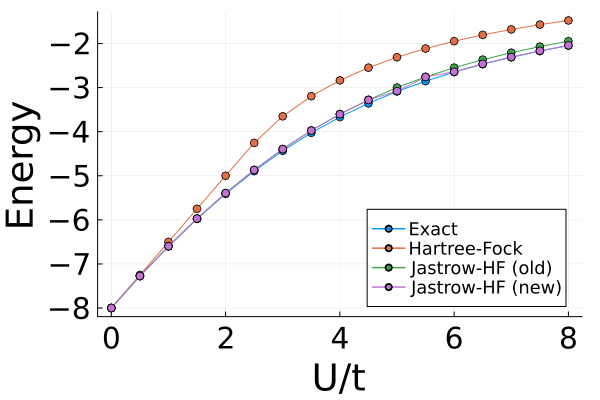

In [37]:
using Plots, Plots.PlotMeasures

plot(ylabel="Energy", xlabel="U/t", tickfontsize=20, labelfontsize=25, bottom_margin=15px, right_margin=10px, legendfontsize=12, legend=:bottomright, leftmargin=10px)

plot!(U_vals, energy_exact, marker=:o, label="Exact")
plot!(U_vals, energy_hf, marker=:o, label="Hartree-Fock")
# plot!(U_vals, energy_hf2, marker=:o, label="Hartree-Fock-2")
# plot!(U_vals, energy_pmg_hf, marker=:o, label="PMG-HF")
plot!(U_vals, energy_jastrow_hf_v1, marker=:o, label="Jastrow-HF (old)")
plot!(U_vals, energy_jastrow_hf, marker=:o, label="Jastrow-HF (new)")
# plot!(U_vals, energy_jastrow_pmg_hf, marker=:o, label="Jastrow-PMG-HF")

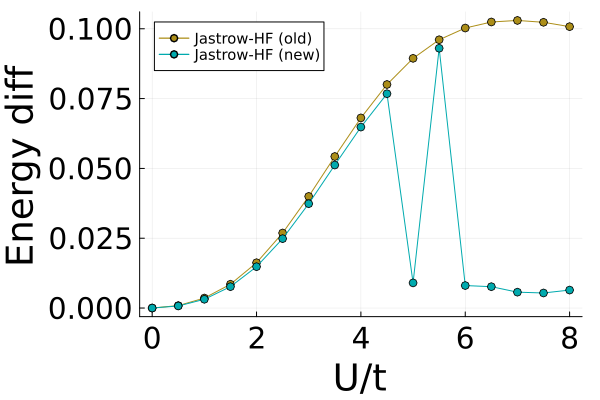

In [43]:
plot(ylabel="Energy diff", xlabel="U/t", tickfontsize=20, labelfontsize=25, bottom_margin=15px, right_margin=10px, legendfontsize=10, legend=:topleft, leftmargin=10px)

# plot!(U_vals, energy_hf .- energy_exact, marker=:o, label="Hartree-Fock", color=2)
# plot!(U_vals, energy_hf2 .- energy_exact, marker=:o, label="Hartree-Fock-2", color=3)
# plot!(U_vals, energy_pmg_hf .- energy_exact, marker=:o, label="PMG-HF", color=4)
plot!(U_vals, energy_jastrow_hf_v1 .- energy_exact, marker=:o, label="Jastrow-HF (old)", color=5)
plot!(U_vals, energy_jastrow_hf .- energy_exact, marker=:o, label="Jastrow-HF (new)", color=6)
# plot!(U_vals, energy_jastrow_pmg_hf .- energy_exact, marker=:o, label="Jastrow-PMG-HF", color=7)

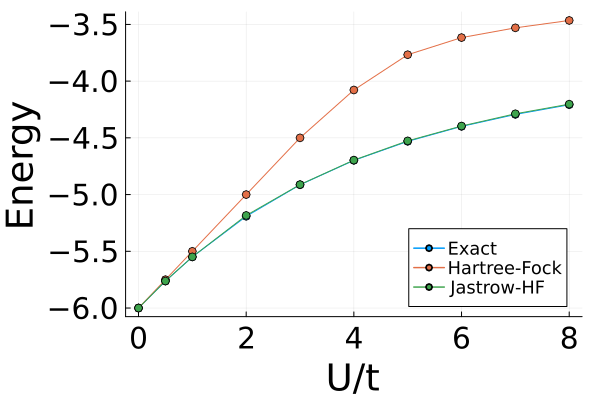

In [39]:
using Plots, Plots.PlotMeasures

plot(ylabel="Energy", xlabel="U/t", tickfontsize=20, labelfontsize=25, bottom_margin=15px, right_margin=10px, legendfontsize=12, legend=:bottomright, leftmargin=10px)

plot!(U_vals, energy_exact, marker=:o, label="Exact")
plot!(U_vals, energy_hf, marker=:o, label="Hartree-Fock")
plot!(U_vals, energy_jastrow_hf, marker=:o, label="Jastrow-HF")

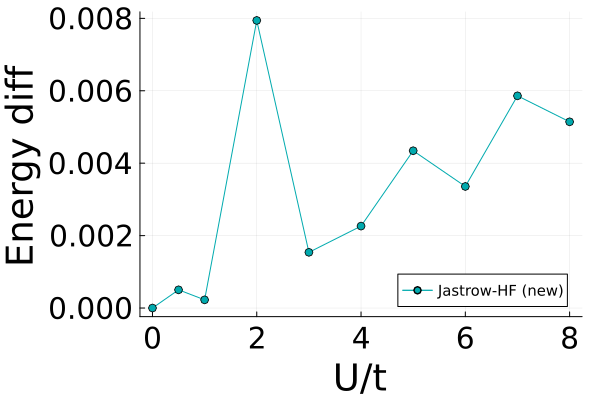

In [41]:
plot(ylabel="Energy diff", xlabel="U/t", tickfontsize=20, labelfontsize=25, bottom_margin=15px, right_margin=10px, legendfontsize=10, legend=:bottomright, leftmargin=10px)

# plot!(U_vals, energy_hf .- energy_exact, marker=:o, label="Hartree-Fock", color=2)
# plot!(U_vals, energy_hf2 .- energy_exact, marker=:o, label="Hartree-Fock-2", color=3)
# plot!(U_vals, energy_pmg_hf .- energy_exact, marker=:o, label="PMG-HF", color=4)
# plot!(U_vals, energy_jastrow_hf_v1 .- energy_exact, marker=:o, label="Jastrow-HF (old)", color=5)
plot!(U_vals, energy_jastrow_hf .- energy_exact, marker=:o, label="Jastrow-HF (new)", color=6)
# plot!(U_vals, energy_jastrow_pmg_hf .- energy_exact, marker=:o, label="Jastrow-PMG-HF", color=7)